# Making Loan Granting Decisions

In this project, we have a loan dataset from a bank. The data contain all the loans asked to the bank, whether the bank decided to grant it, whether the borrower managed to repay it, and the information about the borrower at the moment he/she is asking for the loan. The goal is to build a model to predict whether a customer will repay, which can be used to decide whether to grant loans to future customers.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,make_scorer
from scipy.stats import ks_2samp
from treeinterpreter import treeinterpreter as ti

In [2]:
df_loan  = pd.read_csv('data/loan_table.csv')
df_borrower  = pd.read_csv('data/borrower_table.csv')

# inspect the size of the data
df_loan.shape, df_borrower.shape

((101100, 5), (101100, 12))

In [3]:
df_loan.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN
3,580653,other,2012-06-27,1,1.0
4,172419,business,2012-05-21,1,0.0


In [4]:
df_borrower.head()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1


## Data Cleaning

In [5]:
# Merge the two data frames using "loan_id"
df = pd.merge(left=df_loan, right=df_borrower, how='left', on='loan_id')
# Drop "loan_id" and "date", which are not useful for modeling
df = df.drop(['loan_id','date'],axis=1)

# Rename some columns whose names are too long 
df = df.rename(columns={'fully_repaid_previous_loans': 'previous_repaid', 
                        'currently_repaying_other_loans': 'repaying',
                        'total_credit_card_limit': 'credit_limit', 
                        'avg_percentage_credit_card_limit_used_last_year':'limit_used'})

In [6]:
# Check the amount of NANs in each column
df.isnull().sum()

loan_purpose            0
loan_granted            0
loan_repaid         53446
is_first_loan           0
previous_repaid     54947
repaying            54947
credit_limit            0
limit_used           6972
saving_amount           0
checking_amount         0
is_employed             0
yearly_salary           0
age                     0
dependent_number        0
dtype: int64

There are 53446 NANs in ``loan_repaid``, which should be due to the fact that those customers were not granted the loan in the first place. We can check whether the number of granted loans is also 53446.

In [7]:
# Yes, it is also 53446
print sum(df.loan_granted == 0)

53446


There are 54947 NANs in both ``previous_repaid`` and ``repaying``, which should be due to the fact that those customers never had a loan in the past. We can check whether there are 54947 ones in ``is_first_loan`` 

In [8]:
# Yes, it is also 54947
print sum(df.is_first_loan)

54947


In [9]:
# fill the NANs in "previous_repaid" and "repaying" and make both features 
# have three categories, "NA", "YES", "NO"

df.previous_repaid.fillna(-1,inplace=True)
df.repaying.fillna(-1,inplace=True)
df.previous_repaid = df.previous_repaid.replace({0: 'No', 1: 'Yes', -1: 'NA'})
df.repaying = df.repaying.replace({0: 'No', 1: 'Yes', -1: 'NA'})

Lastly, there are 6972 NANs in ``limit_used``, which should be due to the fact that those customers have no credit card limit at all. We can check whether there are 6972 zeros in ``credit_limit`` 

In [10]:
# Yes, it is also 6972
print sum(df.credit_limit == 0) 

6972


In [11]:
# We can just fill these NANs using zeros
df.limit_used.fillna(0,inplace=True)

The data have the total saving account balance and total checking account balance separately. However, what matters is the total balance, as some people prefer to put most of their money in the checking accounts while some others do not. So here I create a new column ``savings``, which equals the total balance. And then ``saving_amount`` and ``checking_amount`` can be dropped.

In [12]:
print df[['saving_amount','checking_amount']].head(10)

df['savings'] =  df.saving_amount + df.checking_amount
df = df.drop(['saving_amount','checking_amount'],axis=1)

   saving_amount  checking_amount
0           1491             6285
1            141             5793
2            660             3232
3           3345             2764
4           1050             3695
5           1028             3269
6           4206             4368
7            886             1597
8           1837             3795
9            134             1408


## Exploratory Data Analysis and Visualization

### 1. Statistical Overview

Let's check the difference in numbers between the borrowers who repaid and who didn’t

In [13]:
total = sum(df.loan_granted == 1)
df.loan_repaid.value_counts() / total

1.0    0.644353
0.0    0.355647
Name: loan_repaid, dtype: float64

 About 64% of the borrowers did repay

In [14]:
# Numerical features: Didn't repay v.s. Repaid (mean) 
df.groupby('loan_repaid').mean().drop(['loan_granted'],axis=1)

,is_first_loan,credit_limit,limit_used,is_employed,yearly_salary,age,dependent_number,savings
loan_repaid,,,,,,,,
0.0,0.532570,3459.352136,0.718196,0.791952,19893.114232,41.508320,4.233656,3095.128688
1.0,0.545919,5117.599166,0.669510,0.974891,34408.258972,41.533674,3.486843,6860.763857


In [15]:
# Categorical features: Didn't repay v.s. Repaid (mode) 
df.groupby('loan_repaid').agg(lambda x:x.value_counts().index[0])[['loan_purpose','previous_repaid','repaying']]

,loan_purpose,previous_repaid,repaying
loan_repaid,,,
0.0,emergency_funds,NA,NA
1.0,business,NA,NA


- Whether or not a person had previously asked for a loan does not make a differnce, as the mean values of ``is_first_loan`` are almost the same (~54%).
- Age doesn't matter, either. The mean values of ``age`` are almost the same (~41.5).
- For the other numerical features, we can see differences between the two groups. We can later check their distributions
- The most common loan purpose of the people who eventually didn't repay is ``emergency_funds``, while for the people who did repay it is ``business``.


### 2. K-S Tests
A K-S test can be used to test whether two samples are drawn from the same distribution. If the K-S statistic is small or the p-value is high, we cannot reject the null hypothesis that the distributions of the two samples are the same. Here we can use it for ``credit_limit``, ``limit_used``, ``yearly_salary``, ``age``, ``dependent_number`` and ``savings``. Note that for ``is_first_loan`` and ``is_employed``, the values are either 0 or 1, so checking the mean values of the two groups (as shown above) is enough.

In [16]:
def run_KS_test(feature):

    dist1 = df.loc[df.loan_repaid == 0,feature]
    dist2 = df.loc[df.loan_repaid == 1,feature]
    print feature+':'
    print ks_2samp(dist1,dist2),'\n'

run_KS_test('credit_limit')    
run_KS_test('limit_used')
run_KS_test('yearly_salary')
run_KS_test('age')
run_KS_test('dependent_number')
run_KS_test('savings')

credit_limit:
Ks_2sampResult(statistic=0.35322588036422875, pvalue=0.0) 

limit_used:
Ks_2sampResult(statistic=0.15785510619177262, pvalue=2.4726128431945138e-237) 

yearly_salary:
Ks_2sampResult(statistic=0.37714850430190094, pvalue=0.0) 

age:
Ks_2sampResult(statistic=0.0052539473811035187, pvalue=0.92313814108551751) 

dependent_number:
Ks_2sampResult(statistic=0.12093414392822227, pvalue=1.7968807689326007e-139) 

savings:
Ks_2sampResult(statistic=0.70610414704317914, pvalue=0.0) 



We see that the p-value for ``age`` is over 90%, so we cannot reject the null hypothesis. For the others, p-values are all extremely low, showing that the two samples are not drawn from the same distribution.

### 3. Distribution Plots

In [17]:
# Plot the distributions for the numerical features
def DensityPlot(feature):
    fig = plt.figure(figsize=(8,4))
    sns.kdeplot(df.loc[df.loan_repaid == 0,feature], color='r',shade=True, label="didn't repay")
    sns.kdeplot(df.loc[df.loan_repaid == 1,feature], color='b',shade=True, label="repaid")
    plt.xlabel(feature)
    plt.ylabel('frequency')
    plt.show(block=False)

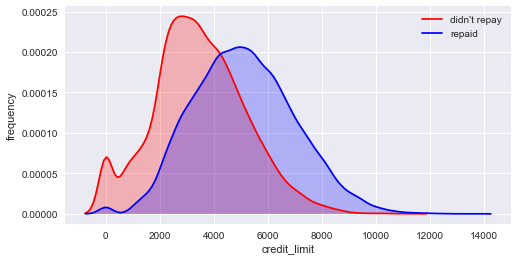

In [18]:
DensityPlot('credit_limit')

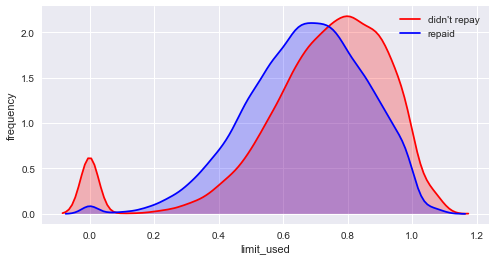

In [19]:
DensityPlot('limit_used')

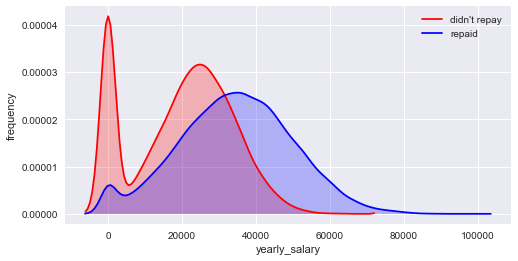

In [20]:
DensityPlot('yearly_salary')

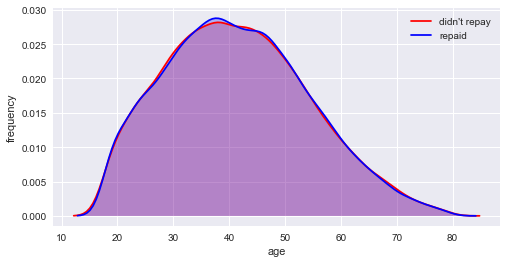

In [21]:
DensityPlot('age')

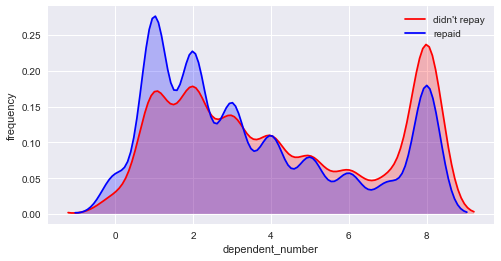

In [22]:
DensityPlot('dependent_number')

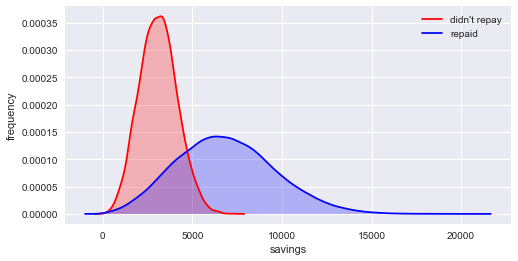

In [23]:
DensityPlot('savings')

- The two distributions of ``age`` are almost identical
- The two distributions of ``dependent_number`` are quite similar, but there are differences at the low and high ends.

In [24]:
# Make count plots for the categorical features
def CountPlot(feature):
    fig = plt.figure()
    sns.countplot(x=feature, hue='loan_repaid', data=df)
    plt.show(block=False)

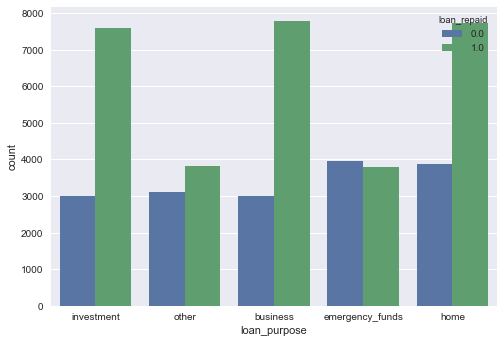

In [25]:
CountPlot('loan_purpose')

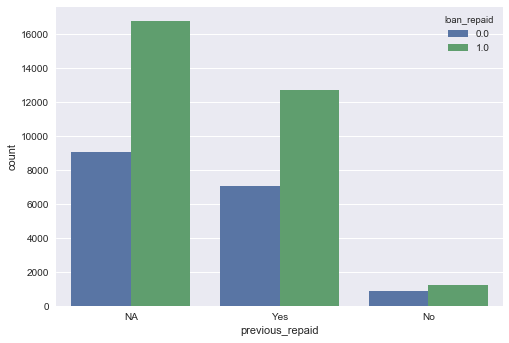

In [26]:
CountPlot('previous_repaid')

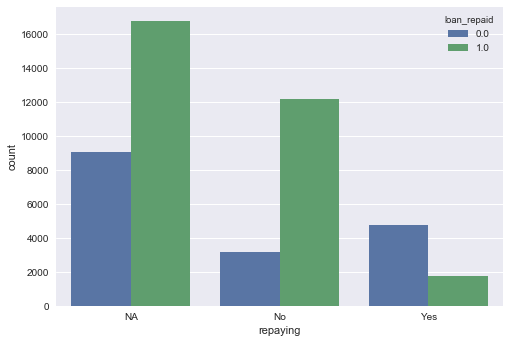

In [27]:
CountPlot('repaying')

- The distributions of ``loan_purpose`` are different between the two groups. It is distributed quite evenly for the borrowers who didn't repay. For the borrowers who repaid, the fractions of ``emergency_funds`` and ``other`` are significantly lower than the other categories.
- In the distributions of ``previous_repaid``, we can see that the borrowers who didn't repay have a higher fraction of people who didn't pay on time all of their previous loans.
- In the distributions of ``repaying``, we can see that the borrowers who didn't repay have a higher fraction of people who are currently repaying other loans.

### 4. Correlation Matrix & Heatmap
Finally let's see the correlations between different numerical features

In [28]:
corr = df.drop(['loan_granted'],axis=1).corr()
corr

,loan_repaid,is_first_loan,credit_limit,limit_used,is_employed,yearly_salary,age,dependent_number,savings
loan_repaid,1.000000,0.012824,0.401911,-0.116388,0.305749,0.426648,0.000947,-0.136384,0.621702
is_first_loan,0.012824,1.000000,0.000679,-0.002585,-0.000971,-0.001674,-0.002353,0.000887,0.006550
credit_limit,0.401911,0.000679,1.000000,0.318143,0.195274,0.222497,-0.004052,-0.058650,0.292580
limit_used,-0.116388,-0.002585,0.318143,1.000000,-0.009516,-0.011848,-0.002836,0.005154,-0.009701
is_employed,0.305749,-0.000971,0.195274,-0.009516,1.000000,0.799051,0.005059,-0.060847,0.302263
yearly_salary,0.426648,-0.001674,0.222497,-0.011848,0.799051,1.000000,0.005412,-0.073218,0.350416
age,0.000947,-0.002353,-0.004052,-0.002836,0.005059,0.005412,1.000000,0.000862,-0.002399
dependent_number,-0.136384,0.000887,-0.058650,0.005154,-0.060847,-0.073218,0.000862,1.000000,-0.097528
savings,0.621702,0.006550,0.292580,-0.009701,0.302263,0.350416,-0.002399,-0.097528,1.000000


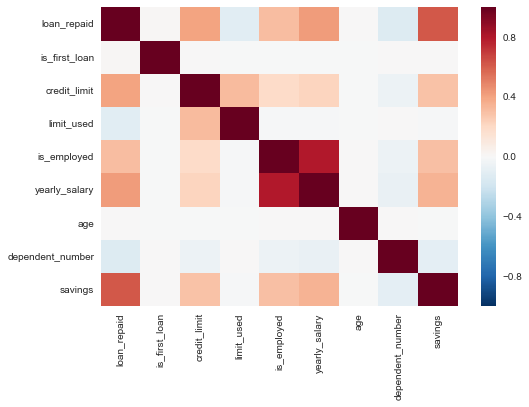

In [29]:
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values)
plt.show()

- The features that correlate with ``loan_repaid`` most are ``savings``, ``yearly_salary``, ``credit_limit``, and ``is_employed``.
- ``age`` and ``is_first_loan`` do not correlate with other features.

## Data Transformation and Train/Test Split

First, we have to transform the categories in categorical features to numerical values.

In [30]:
# Use dummy variables
df = pd.get_dummies(df,columns=['loan_purpose','previous_repaid','repaying'])
# Drop one dummy variable for each of the three features to avoid dummy variable trap
df = df.drop(['loan_purpose_other','previous_repaid_NA','repaying_NA'],axis=1)

We actually don't need ``is_first_loan`` anymore, because this information is in ``previous_repaid`` and ``repaying`` already. We will also drop ``age`` since it is irrelevant.

In [31]:
df = df.drop(['is_first_loan','age'],axis=1)

Now we have to split the data into three. First, the customers who were not granted loans have to be taken out because we don't know whetehr they would have repaid. Thus, they cannot be used for modeling. Secondly, I will split the remaining data into a training set and a test set, using a 70/30 split.

In [32]:
# Those people that were not granted loans
X_notgranted = df[df.loan_granted == 0].reset_index(drop=True).drop(['loan_granted','loan_repaid'],axis=1)

# Those that were granted loans
X = df[df.loan_granted == 1].reset_index(drop=True).drop(['loan_granted','loan_repaid'],axis=1)
Y = df[df.loan_granted == 1].reset_index(drop=True)['loan_repaid'].values # target variable

# Train/Test split
X_train, X_test, Y_train, Y_test =  train_test_split(X, Y, test_size=0.3, random_state=0)

Because not all the features have the same scale, here I scale them using ``StandardScaler``. The standardizer is fit to the training set only, and then used to transform both the training and test sets as well as the data for the customers that were not granted loans.

In [33]:
scaler = StandardScaler()

# After the performing the standardization, transform them back to data frames
# in order to keep the column names
X_train = pd.DataFrame(scaler.fit_transform(X_train.values), columns=X.columns)
X_test = pd.DataFrame(scaler.transform(X_test.values), columns=X.columns)
X_notgranted = pd.DataFrame(scaler.transform(X_notgranted.values), columns=X.columns)

## Logistic regression

Here I try Logistic regression and use ``GridSearchCV`` to tune the hyperparameters. The good thing about Logistic regression is that it is easy to interpret and also faster than more complicated models. Later I will also try Random Forest classifier and see whether or not the performance improves significantly. 
<br><br>
In this loan granting problem, both precision (the fraction of people who eventually repay among all the borrowers) and recall (the fraction of customers who are granted loans among all of those who would repay) are important. I therefore use F1 score as the main evaluation metric.

In [34]:
# Use F1 score for GridSearchCV
f1 = make_scorer(f1_score)

lr = LogisticRegression()

# specify parameters and distributions to sample from
C_grid = 0.001*10**(np.arange(0,1.01,0.01)*3)
parameters = {"C": C_grid}


grid_search = GridSearchCV(estimator = lr,
                           param_grid = parameters,
                           scoring = f1, 
                           n_jobs = -1)

grid_search = grid_search.fit(X_train, Y_train)

print grid_search.best_score_
print grid_search.best_params_
lr = grid_search.best_estimator_

0.920907628916
{'C': 0.011220184543019636}


In [35]:
Y_pred = lr.predict(X_test)
Y_train_pred = lr.predict(X_train)

print "--- Accuracy ---"
print "Training Set:",lr.score(X_train, Y_train)
print "Test Set:",lr.score(X_test, Y_test)

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
print "\n--- Confusion Matrix ---"
print "True Positive:", tp
print "False Negative:", fn
print "True Negative:", tn
print "False Positive:", fp

print "\n--- Precision ---"
print "Training Set:",precision_score(Y_train, Y_train_pred)
print "Test Set:",precision_score(Y_test, Y_pred)

print "\n--- Recall ---"
print "Training Set:",recall_score(Y_train, Y_train_pred)
print "Test Set:",recall_score(Y_test, Y_pred)

print "\n--- F1 Score ---"
print "Training Set:",f1_score(Y_train, Y_train_pred)
print "Test Set:",f1_score(Y_test, Y_pred)

--- Accuracy ---
Training Set: 0.899001708787
Test Set: 0.898160453242

--- Confusion Matrix ---
True Positive: 8509
False Negative: 777
True Negative: 4332
False Positive: 679

--- Precision ---
Training Set: 0.926274028244
Test Set: 0.926099259904

--- Recall ---
Training Set: 0.915592903828
Test Set: 0.916325651518

--- F1 Score ---
Training Set: 0.920902495715
Test Set: 0.921186532424


In order to compare the profitability of my model and the profitability the bank actually made (for the test set), I assume:
- If the loan is granted and the it doesn't get repaid, we lose 1
- If the loan is granted and the it does get repaid, we gain 1
- We gain 0 if the loan is not granted

In [36]:
# bank
score_bank = sum(Y_test == 1) - sum(Y_test == 0)
# my Logistic regression model
score_lr = tp - fp

print "The bank scores {} points".format(score_bank)
print "The Logistic regression model scores {} points".format(score_lr)

The bank scores 4275 points
The Logistic regression model scores 7830 points


We can see that it is a great improvement. But of course, this is not a fair comparison because I am using existing data of borrowers to train my model while the bank didn't have these data (or had much less data) to begin with.

How about the people who were not granted loans? We can use my model to predict what would happen.

In [37]:
# Calculate the fraction of people who would have been granted 
# loans based on my model among those customers who were not 
# granted loans

Y_notgranted_pred = lr.predict(X_notgranted)
print Y_notgranted_pred.sum()/len(Y_notgranted_pred)

0.340960969951


Based on the model, about 34% of the people who didn't get loans would actually repay and should be granted. If we assume the ratio of true positive over false positive that I got for the test set, we can estimate the profitability we would get if we grant loans to those 34%.

In [38]:
tp_pred = int(round(Y_notgranted_pred.sum()*tp*1./(tp+fp)))
fp_pred = int(round(Y_notgranted_pred.sum()*fp*1./(tp+fp)))
print "Predicted true positive: ", tp_pred
print "Predicted false positive: ", fp_pred
print "The estimated profitability: {} points".format(tp_pred - fp_pred)

Predicted true positive:  16876
Predicted false positive:  1347
The estimated profitability: 15529 points


One very important thing for a loan granting problem is to interpret the results. Especially, for the customers we reject, we should provide the reasons why they are not granted loans. For the results from Logistic regression, we can check the contributions from each features and find out the dominant ones that make the prediction to be 0 (won't repay). Here I use the first three instances of the test set as the examples.

In [39]:
# the predictions for these three instances are 0, 1, 0
Y_pred[0:3]

array([ 0.,  1.,  0.])

To check the contributions from each features, we can multiply the feature values by the corresponding weights of decision function.

In [40]:
# instance 0: feature values
# negative/positive values mean below/above average
X_test.loc[0,:]

credit_limit                   -1.024036
limit_used                      1.817212
is_employed                    -3.175226
yearly_salary                  -1.795773
dependent_number               -0.290484
savings                        -0.715252
loan_purpose_business           1.857890
loan_purpose_emergency_funds   -0.440803
loan_purpose_home              -0.567830
loan_purpose_investment        -0.534955
previous_repaid_No             -0.215091
previous_repaid_Yes            -0.840952
repaying_No                    -0.689246
repaying_Yes                   -0.397426
Name: 0, dtype: float64

In [41]:
# instance 0: feature values times the weights
np.round(X_test.loc[0,:] * lr.coef_.reshape(-1),3)

credit_limit                   -0.988
limit_used                     -0.708
is_employed                    -0.337
yearly_salary                  -1.735
dependent_number                0.064
savings                        -1.791
loan_purpose_business           0.492
loan_purpose_emergency_funds    0.048
loan_purpose_home              -0.094
loan_purpose_investment        -0.119
previous_repaid_No              0.011
previous_repaid_Yes             0.000
repaying_No                    -0.227
repaying_Yes                    0.190
Name: 0, dtype: float64

We see that low ``savings``, low ``yearly_salary``, low ``credit_limit`` and high ``limit_used`` are the most dominant factors that result in the rejection. In the following, I calculate the predicted probability that this customer will repay (instead of 0 or 1)

In [42]:
# the inner product of feature vector and the weight vector plus the bias term
z = sum(X_test.loc[0,:] * lr.coef_.reshape(-1)) + lr.intercept_[0]
# apply sigmoid function
p = 1.0/(1+np.exp(-z))
print "Prediction (probability): ", round(p,3)

Prediction (probability):  0.03


Let's do the same exercise for the second instance

In [43]:
# instance 1: feature values
# negative/positive values mean below/above average
X_test.loc[1,:]

credit_limit                   -0.516832
limit_used                     -1.377685
is_employed                     0.314938
yearly_salary                   0.810202
dependent_number               -0.672976
savings                         0.339149
loan_purpose_business           1.857890
loan_purpose_emergency_funds   -0.440803
loan_purpose_home              -0.567830
loan_purpose_investment        -0.534955
previous_repaid_No             -0.215091
previous_repaid_Yes             1.189128
repaying_No                    -0.689246
repaying_Yes                    2.516189
Name: 1, dtype: float64

In [44]:
# instance 1: feature values times the weights
np.round(X_test.loc[1,:] * lr.coef_.reshape(-1),3)

credit_limit                   -0.498
limit_used                      0.537
is_employed                     0.033
yearly_salary                   0.783
dependent_number                0.149
savings                         0.849
loan_purpose_business           0.492
loan_purpose_emergency_funds    0.048
loan_purpose_home              -0.094
loan_purpose_investment        -0.119
previous_repaid_No              0.011
previous_repaid_Yes            -0.001
repaying_No                    -0.227
repaying_Yes                   -1.205
Name: 1, dtype: float64

We see that high ``savings`` and ``yearly_salary``, and low ``limit_used`` are the most dominant factors that result in the approval. We again calculate the predicted probability that this customer will repay below.

In [45]:
# the inner product of feature vector and the weight vector plus the bias term
z = sum(X_test.loc[1,:] * lr.coef_.reshape(-1)) + lr.intercept_[0]
# apply sigmoid function
p = 1.0/(1+np.exp(-z))
print "Prediction (probability): ", round(p,3)

Prediction (probability):  0.922


Let's do the same exercise for the third instance

In [46]:
# instance 2: feature values
# negative/positive values mean below/above average
X_test.loc[2,:]

credit_limit                   -0.263230
limit_used                      1.867132
is_employed                    -3.175226
yearly_salary                  -1.795773
dependent_number               -1.055468
savings                        -0.709365
loan_purpose_business          -0.538245
loan_purpose_emergency_funds    2.268588
loan_purpose_home              -0.567830
loan_purpose_investment        -0.534955
previous_repaid_No             -0.215091
previous_repaid_Yes            -0.840952
repaying_No                    -0.689246
repaying_Yes                   -0.397426
Name: 2, dtype: float64

In [47]:
# instance 2: feature values times the weights
np.round(X_test.loc[2,:] * lr.coef_.reshape(-1),3)

credit_limit                   -0.254
limit_used                     -0.728
is_employed                    -0.337
yearly_salary                  -1.735
dependent_number                0.233
savings                        -1.776
loan_purpose_business          -0.143
loan_purpose_emergency_funds   -0.245
loan_purpose_home              -0.094
loan_purpose_investment        -0.119
previous_repaid_No              0.011
previous_repaid_Yes             0.000
repaying_No                    -0.227
repaying_Yes                    0.190
Name: 2, dtype: float64

We again see that low ``savings``, low ``yearly_salary``, high ``limit_used`` and unemployment (``is_employed``) are the most dominant factors that result in the rejection.

In [48]:
# the inner product of feature vector and the weight vector plus the bias term
z = sum(X_test.loc[2,:] * lr.coef_.reshape(-1)) + lr.intercept_[0]
# apply sigmoid function
p = 1.0/(1+np.exp(-z))
print "Prediction (probability): ", round(p,3)

Prediction (probability):  0.029


## Random Forest Classifier

Now I will try Random Forest classifier. Let's see if it performs significantly better than the Logistic regression (which in this case simply makes a linear decision boundary to separate the positive and negative examples).

In [49]:
rf = RandomForestClassifier()

# Specify parameters and distributions to sample from
parameters = {"n_estimators": [100],
              "max_features": [2,3,4,5],
              "min_samples_split": [2,3,4,5],
              "min_samples_leaf": [1,2,3,4,5],
              "criterion": ["entropy"],
              "random_state": [0]}

# Run Grid Search
grid_search = GridSearchCV(estimator = rf,
                           param_grid = parameters,
                           scoring = f1,
                           n_jobs = -1)

grid_search = grid_search.fit(X_train, Y_train)

print grid_search.best_score_
print grid_search.best_params_
rf = grid_search.best_estimator_

0.923837543708
{'min_samples_leaf': 4, 'n_estimators': 100, 'min_samples_split': 2, 'random_state': 0, 'criterion': 'entropy', 'max_features': 4}


In [50]:
Y_pred = rf.predict(X_test)
Y_train_pred = rf.predict(X_train)

print "--- Accuracy ---"
print "Training Set:",rf.score(X_train, Y_train)
print "Test Set:",rf.score(X_test, Y_test)

tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
print "\n--- Confusion Matrix ---"
print "True Positive:", tp
print "False Negative:", fn
print "True Negative:", tn
print "False Positive:", fp

print "\n--- Precision ---"
print "Training Set:",precision_score(Y_train, Y_train_pred)
print "Test Set:",precision_score(Y_test, Y_pred)

print "\n--- Recall ---"
print "Training Set:",recall_score(Y_train, Y_train_pred)
print "Test Set:",recall_score(Y_test, Y_pred)

print "\n--- F1 Score ---"
print "Training Set:",f1_score(Y_train, Y_train_pred)
print "Test Set:",f1_score(Y_test, Y_pred)

--- Accuracy ---
Training Set: 0.950235332914
Test Set: 0.904175701196

--- Confusion Matrix ---
True Positive: 8505
False Negative: 781
True Negative: 4422
False Positive: 589

--- Precision ---
Training Set: 0.969314079422
Test Set: 0.935232021113

--- Recall ---
Training Set: 0.952661064426
Test Set: 0.915894895542

--- F1 Score ---
Training Set: 0.960915426634
Test Set: 0.925462459195


The performance of this model is only a little better than the Logistic regression.

In [51]:
# bank
score_bank = sum(Y_test == 1) - sum(Y_test == 0)
# my Logistic regression model
score_rf = tp - fp

print "The bank scores {} points".format(score_bank)
print "The Random Forest classifier scores {} points".format(score_rf)

The bank scores 4275 points
The Random Forest classifier scores 7916 points


The score of 7916 points is only a little higher than the score of the Logistic regression (7830 points)

How about the people who were not granted loans?

In [52]:
# Calculate the fraction of people who would have been granted 
# loans based on my model among those customers who were not 
# granted loans

Y_notgranted_pred = rf.predict(X_notgranted)
print Y_notgranted_pred.sum()/len(Y_notgranted_pred)

0.343748830595


Again, about 34% of the people who didn't get loans would actually repay based on the model. Assuming the ratio of true positive over false positive I got above, we can estimate the profitability we would get if these 34% are granted loans.

In [53]:
tp_pred = int(round(Y_notgranted_pred.sum()*tp*1./(tp+fp)))
fp_pred = int(round(Y_notgranted_pred.sum()*fp*1./(tp+fp)))
print "Predicted true positive: ", tp_pred
print "Predicted false positive: ", fp_pred
print "The estimated profitability: {} points".format(tp_pred - fp_pred)

Predicted true positive:  17182
Predicted false positive:  1190
The estimated profitability: 15992 points


To interpret the results from a decision tree or random forest, we can use the [treeinterpreter](https://github.com/andosa/treeinterpreter) (also see [this](http://blog.datadive.net/interpreting-random-forests/) and [this](http://blog.datadive.net/random-forest-interpretation-with-scikit-learn/) blog posts). Again, I will use the first three instances of the test set as the examples.

In [54]:
instances = X_test.loc[0:2,:]

# see the links above for "treeinterpreter" 
prediction, bias, contribution = ti.predict(rf, instances)

for i in range(len(instances)):
    print "Instance", i
    print "Prediction: ", round(prediction[i,1],3)
    print "Bias (training set mean value): ", round(bias[i,1],3)
    print "Feature contributions:"
    
    # The feature contributions are sorted by their absolute impact
    for c,feature in sorted(zip(contribution[i,:,1],X_train.columns.values), 
                             key=lambda x: -abs(x[0])):
        print feature, round(c, 3)
    print "-"*20 

Instance 0
Prediction:  0.028
Bias (training set mean value):  0.642
Feature contributions:
savings -0.247
is_employed -0.193
credit_limit -0.089
yearly_salary -0.086
repaying_Yes 0.026
limit_used -0.024
loan_purpose_business 0.02
repaying_No -0.016
previous_repaid_Yes -0.004
dependent_number -0.004
loan_purpose_emergency_funds 0.003
loan_purpose_investment -0.0
previous_repaid_No 0.0
loan_purpose_home 0.0
--------------------
Instance 1
Prediction:  0.929
Bias (training set mean value):  0.642
Feature contributions:
savings 0.363
repaying_Yes -0.13
yearly_salary 0.111
credit_limit -0.073
limit_used 0.021
is_employed 0.012
previous_repaid_Yes -0.009
repaying_No -0.009
dependent_number -0.007
loan_purpose_business 0.003
loan_purpose_emergency_funds 0.002
loan_purpose_investment 0.002
loan_purpose_home -0.0
previous_repaid_No 0.0
--------------------
Instance 2
Prediction:  0.008
Bias (training set mean value):  0.642
Feature contributions:
savings -0.249
is_employed -0.198
yearly_salary

- instance 0: ``savings``, ``is_employed``, ``credit_limit``, and ``yearly_salary`` are the most dominant factors that result in the rejection.
- instance 1: ``savings`` and ``yearly_salary`` are the most dominant factors that result in the approval.
- instance 2: ``savings``, ``is_employed``, ``yearly_salary``, and ``credit_limit`` are the most dominant factors that result in the rejection.

Interestingly, ``is_employed`` plays a more important role in this Random Forest classifier than in the Logistic regression, showing the difference of decision boundary between the two models. Intuitively, ``is_employed`` should be a very important factor to decide whether to grant loan to a costumer, since an unemployed person usually doesn't have steady income and will be most likely unable to repay.